# Diminutive Suffix Productivity: cleaning and exploratory  analysis
Juan Berrios | jeb358@pitt.edu | Last updated: April 24, 2020

**Summary and overview:**

- This notebook is a continuation of the [corpus processing notebook](https://github.com/Data-Science-for-Linguists-2020/Diminutive-Suffix-Productivity/blob/master/code/corpus_processing.ipynb) in my repository. The purpose is to finish cleaning the data frame objects I've built (which were previously pickled in order to be loaded here) and create a master, cross-dialectal data frame for exploratory analysis.

**Contents:**
1. [Preparation](#1.-Preparation): includes the necessary preparations and loading of the files.
2. [Further cleaning and manipulation](#2.-Further-cleaning-and-manipulation): includes code for performing further cleaning on the data. New, refined columns needed for explatory analysis are also added.
3. [Exploratory analysis](#3.-Exploratory-analysis): the start of the analysis, with a focus on descriptive statistics and data visualization.
4. [Storing files](#4.-Storing-files): includes code for storing the results as pickled files.

## 1. Preparation

- Loading libraries and additional settings:

In [1]:
#Importing libraries
import pickle, re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Turning pretty print off:
%pprint

# Settings for plotting

matplotlib.rcParams['font.sans-serif'] = "Century Gothic"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.labelsize'] = 14

#Releasing all output:                                            
from IPython.core.interactiveshell import InteractiveShell #Prints all commands rather than the last one.
InteractiveShell.ast_node_interactivity = "all"

Pretty printing has been turned OFF


- Loading pickle files:

In [2]:
ar_DF = pd.read_pickle('pkl/ar_DF.pkl')
bo_DF = pd.read_pickle('pkl/bo_DF.pkl')
cl_DF = pd.read_pickle('pkl/cl_DF.pkl')
co_DF = pd.read_pickle('pkl/co_DF.pkl')
cr_DF = pd.read_pickle('pkl/cr_DF.pkl')
cu_DF = pd.read_pickle('pkl/cu_DF.pkl')
do_DF = pd.read_pickle('pkl/do_DF.pkl')
ec_DF = pd.read_pickle('pkl/ec_DF.pkl')
es_DF = pd.read_pickle('pkl/es_DF.pkl')
gt_DF = pd.read_pickle('pkl/gt_DF.pkl')
hn_DF = pd.read_pickle('pkl/hn_DF.pkl')
mx_DF = pd.read_pickle('pkl/mx_DF.pkl')
ni_DF = pd.read_pickle('pkl/ni_DF.pkl')
pa_DF = pd.read_pickle('pkl/pa_DF.pkl')
pe_DF = pd.read_pickle('pkl/pe_DF.pkl')
pr_DF = pd.read_pickle('pkl/pr_DF.pkl')
py_DF = pd.read_pickle('pkl/py_DF.pkl')
sv_DF = pd.read_pickle('pkl/sv_DF.pkl')
us_DF = pd.read_pickle('pkl/us_DF.pkl')
uy_DF = pd.read_pickle('pkl/uy_DF.pkl')

- Looks good. Now let's take a first look at the size (number of rows, since all have 6 colums) of the data frames as they are:

In [3]:
#Getting the number of rows in every variety data frame:

variety_tups = [('Argentina', ar_DF), ('Bolivia', bo_DF), ('Chile', cl_DF), ('Colombia', co_DF), ('Costa Rica', cr_DF),
                ('Cuba', cu_DF), ('Dominican Republic', do_DF), ('Ecuador', ec_DF), ('Spain', es_DF), 
                ('Guatemala', gt_DF), ('Honduras', hn_DF), ('Mexico', mx_DF), ('Nicaragua', ni_DF), ('Panama', pa_DF),
                ('Peru', pe_DF), ('Puerto Rico', pr_DF), ('Paraguay', py_DF), ('El Salvador', sv_DF), 
                ('United States', us_DF), ('Uruguay', uy_DF)]

for (name,df) in variety_tups:
    print(name,'rows:',df.shape[0])

Argentina rows: 660311
Bolivia rows: 154638
Chile rows: 268361
Colombia rows: 693246
Costa Rica rows: 136838
Cuba rows: 233697
Dominican Republic rows: 156046
Ecuador rows: 250880
Spain rows: 1872540
Guatemala rows: 242961
Honduras rows: 148014
Mexico rows: 1012937
Nicaragua rows: 140314
Panama rows: 104494
Peru rows: 483191
Puerto Rico rows: 157161
Paraguay rows: 112066
El Salvador rows: 159553
United States rows: 679110
Uruguay rows: 147800


- And as a last step to use less memory and write shorter, more efficient code let's build a master data frame that includes all varieties. Since there is a `Variety` column that I added in the first notebook, the rows can be properly identified and I can go back to the individual by-variety data frames if needed. I'll also verify how large it is.

In [4]:
master_DF = pd.concat([ar_DF, bo_DF, cl_DF, co_DF, cr_DF, cu_DF, do_DF, ec_DF, es_DF, gt_DF, hn_DF,
                mx_DF, ni_DF, pa_DF, pe_DF, pr_DF, py_DF, sv_DF, us_DF, uy_DF], sort=True)

In [5]:
print('Master rows:', master_DF.shape[0])

Master rows: 7814158


- I noticed that some data frames had NaN values, which might be why I was running into some issues in the prior notebook (the test one didn't have any). To make sure that won't be a problem anymore I'll drop those rows:

In [6]:
master_DF = master_DF.dropna() 

In [7]:
print('Master rows:', master_DF.shape[0])

Master rows: 7814158


In [8]:
master_DF.keys() #The order of the columns was shuffled, to turn it back:

Index(['Lemma', 'POS', 'SourceID', 'TokenID', 'Variety', 'Word'], dtype='object')

In [9]:
master_DF = master_DF[['SourceID', 'TokenID', 'Lemma', 'Word', 'POS', 'Variety']]

In [10]:
master_DF.keys() #Success

Index(['SourceID', 'TokenID', 'Lemma', 'Word', 'POS', 'Variety'], dtype='object')

## 2. Further cleaning and manipulation

- In the first notebook I reduced a gigantic amount (30GB when zipped) of data to manageable smaller sizes. The data frames as they are only include tokens that end in the segments of interest. The problem is that many of those just happen to end in the same segments as diminutives but are not diminutives themselves. To solve this problem, let's first remove categories to which the morphological pattern doesn't apply (and refine the POS column in the process):

In [11]:
master_DF['POS'].value_counts() #Most of this I don't need

n           1344048
nms         1244791
o            863537
nmp          743416
nfs          685679
vip-3s       587155
nfp          402123
jms          355214
j            352325
jfs          314719
vip-1s       224604
vps-ms       124389
jmp          116276
jfp          108247
vsp-1/3s      95586
vip-2s        80953
r             48042
v             43731
vps-fs        34918
vps-mp        18749
vps-fp        13627
vsp-2s         6653
x              1891
np             1509
m$             1080
i               402
vr              208
fn              153
vm-2s            99
xy               17
e                13
y                 3
vm-3s             1
Name: POS, dtype: int64

In [12]:
master_DF = master_DF[master_DF['POS'].str.contains('n|j')] #Extracts only noun and adjective classes. A very limited
                                                            #set of gerunds can also take diminutive suffixes but the 
                                                            #amount is negligeable and won't be enough for analysis so 
                                                            #I'll exclude them.

In [13]:
master_DF.shape #Current size

(5668500, 6)

In [14]:
master_DF['POS'].value_counts() #That last category is the only one that shouldn't be there. Let's remove it.

n          1344048
nms        1244791
nmp         743416
nfs         685679
nfp         402123
jms         355214
j           352325
jfs         314719
jmp         116276
jfp         108247
np            1509
fn             153
Name: POS, dtype: int64

In [15]:
master_DF = master_DF[master_DF['POS'] != ('fn')] 

In [16]:
master_DF['POS'].value_counts() #Success. 

n          1344048
nms        1244791
nmp         743416
nfs         685679
nfp         402123
jms         355214
j           352325
jfs         314719
jmp         116276
jfp         108247
np            1509
Name: POS, dtype: int64

In [17]:
master_DF.sample(5) #Let's take a sample to make sure all's going well:

,SourceID,TokenID,Lemma,Word,POS,Variety
380032,679687,1409979992,maravilla,maravillas,nfp,GT
4173596,1351055,887523159,bonito,bonita,jfs,AR
2543775,1446286,1058176854,electrólito,Electrolito,n,CL
2556858,349003,297667573,visita,visita,nfs,CU
22606307,627476,1108025528,bonito,bonito,jms,ES


- The POS column provides useful information that I might use for linguistic analysis, so let's refine it:

In [18]:
master_DF['POS'].unique()

array(['nmp    ', 'nfs    ', 'n', 'jfs    ', 'nms    ', 'nfp    ', 'j',
       'jms    ', 'jmp    ', 'jfp    ', 'np'], dtype=object)

- There are two main problems here. First, that for some reason I couldn't find in the documentation some tokens were not tagged for gender and number (those tagged 'j' and 'n'). Secondly, there is extraneous white space in some categories, which was giving me issues when first trying out the code. Let's take care of one issue at a time:

In [19]:
master_DF['POS'] = master_DF['POS'].str.strip()

In [20]:
master_DF['POS'].unique() #White space problem solved

array(['nmp', 'nfs', 'n', 'jfs', 'nms', 'nfp', 'j', 'jms', 'jmp', 'jfp',
       'np'], dtype=object)

- Now I'll create a simplified, binary POS column where each token is either a noun or an adjective. Let's also make the coding more transparent while we are at it:

In [21]:
pos_dict = {'n': 'Noun', 'nms': 'Noun', 'nfs': 'Noun', 'nmp': 'Noun', 'nfp': 'Noun', 'np': 'Noun', 
             'j': 'Adjective', 'jms': 'Adjective', 'jfs': 'Adjective', 'jmp': 'Adjective', 'jfp': 'Adjective'}

In [22]:
master_DF['POS_binary'] = master_DF['POS'].map(pos_dict)

In [23]:
master_DF.sample(10) #It works. 

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary
4234567,45113,525214390,éxito,éxito,n,AR,Noun
254468,950346,2432259227,éxito,éxito,n,PA,Noun
3095168,27427,2301516271,señorita,señoritas,nfp,AR,Noun
2307366,1226188,2392407285,hito,hito,nms,UY,Noun
6087471,1167187,2266741804,jesuita,jesuita,nms,US,Noun
26293821,670983,517613074,sencillo,Sencilla,jfs,ES,Adjective
3138532,787177,1273949200,costilla,costillas,nfp,MX,Noun
1258068,1096329,1799986229,plumilla,plumilla,nfs,SV,Noun
173972,749938,1719374860,mita,mita,nfs,MX,Noun
5937614,1529475,2537406561,bebito,bebita,n,CO,Noun


- As a solution for tokens that are not tagged for gender and number I'll create an 'Unknown label'. It is also possible to write code that will tag them based on certain patterns. Since that is not the focus of my analysis I won't do that now, but I might come back here if I have some extra time later. 

In [24]:
#Build dictionaries that map POS into desired gender and number values:

number_dict = {'n': 'unknown', 'nms': 'singular', 'nfs': 'singular', 'nmp': 'plural', 'nfp': 'plural', 
                  'np': 'unknown', 'j': 'unknown', 'jms': 'singular', 'jfs': 'singular', 'jmp': 'plural', 
                  'jfp': 'plural'}

gender_dict = {'n': 'unknown', 'nms': 'masculine', 'nfs': 'feminine', 'nmp': 'masculine', 'nfp': 'feminine', 
                  'np': 'unknown', 'j': 'unknown', 'jms': 'masculine', 'jfs': 'feminine', 'jmp': 'masculine', 
                  'jfp': 'feminine'}

In [25]:
master_DF['Number'] = master_DF['POS'].map(number_dict) #Map new values

In [26]:
master_DF.sample(5) #Works well

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number
893299,970960,1692714350,éxito,éxito,n,PE,Noun,unknown
2657441,353278,1542506309,pegadito,pegadita,j,CU,Adjective,unknown
1512551,1607457,1348219893,cadillo,cadillos,nmp,DO,Noun,plural
527979,367815,2328663102,mito,mitos,nmp,DO,Noun,plural
6132074,1709254,563525381,sevilla,Sevilla,n,ES,Noun,unknown


In [27]:
master_DF['Gender'] = master_DF['POS'].map(gender_dict)  #Map new values

In [28]:
master_DF.sample(5) #Works well

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number,Gender
260573,2247686,1165148047,caudillo,caudillo,nms,SV,Noun,singular,masculine
351855,306486,2213482662,sencillo,sencillo,j,CR,Adjective,unknown,unknown
4745311,803165,1024965850,pandilla,pandilla,nfs,MX,Noun,singular,feminine
177574,1045539,1858138589,implícito,implícita,jfs,PR,Adjective,singular,feminine
14025062,2103428,1581944946,sermoncito,sermoncitos,n,MX,Noun,unknown,unknown


-  Now the last (and most difficult) cleaning task. Even after removing millions of rows in prior steps, there are still many tokens that do not belong in the data frame because they are (i) lexicalized forms that have acquired a meaning of their own, or (ii) words that meet the word class and phonological requirement but simply do not happen to be diminutives. At first, I was going to try to solve this using a dictionary of Spanish as a list that I could cross-compare with the `Lemma` column. This is because diminutivized forms with a predictable meaning wouldn't show up in such a list. I couldn't find such a resource, though, and making one manually would take a really long time. Conversely and based on my knowledge of the topic, the forms I want to remove are much more frequent than diminutivized forms. It follows that if I extract a list of highly frequent forms from the corpus that end in the segments of interest I can get a list that I can later cross-compare with my data frame's `Lemma` column. Coincidentally, the corpus offers a useful resource for this purpose; that is, a lexicon. I'll load that, derive a frequency-based list of lemmas I want to exclude from the data frame from there, and then actually excluse those from the `master_DF` object:

In [29]:
#Loading lexicon. I'll include code for removing white spaces since I'm aware of them now. 

fname = '../../Diminutive-Suffix-Productivity/private/data/span_lexicon/span_dic.txt'   
lexicon = pd.read_csv(fname,sep='\t',encoding='iso-8859-1',skiprows=[1],converters={'PoS': str.strip}, 
                      low_memory=False) #Low memory setting require due to NaN values.

In [30]:
lexicon #A new, lexicon data frame

,wID,word,lemma,PoS
0,1,",","$,",y
1,2,de,de,e
2,3,.,$.,y
3,4,la,la,ld-fs
4,5,y,y,cc
...,...,...,...,...
8754578,11925785,@@999948,NaN,
8754579,11925786,@@99996,NaN,
8754580,11925787,@@999965,NaN,
8754581,11925788,@@999974,NaN,


In [31]:
lexicon = lexicon.rename(columns={"wID": "WordID", "word": "Word", "lemma": "Lemma", "PoS": "POS"}) #Renaming columns.
lexicon

,WordID,Word,Lemma,POS
0,1,",","$,",y
1,2,de,de,e
2,3,.,$.,y
3,4,la,la,ld-fs
4,5,y,y,cc
...,...,...,...,...
8754578,11925785,@@999948,NaN,
8754579,11925786,@@99996,NaN,
8754580,11925787,@@999965,NaN,
8754581,11925788,@@999974,NaN,


In [32]:
lexicon = lexicon.dropna() #Dropping NaN values (non-words that appear at the end of the data frame)
lexicon

,WordID,Word,Lemma,POS
0,1,",","$,",y
1,2,de,de,e
2,3,.,$.,y
3,4,la,la,ld-fs
4,5,y,y,cc
...,...,...,...,...
8474411,11645618,descabellados,descabellar,v
8474412,11645619,hacendados,hacendar,v
8474413,11645620,reposeídas,reposeer,v
8474414,11645621,remozadas,remozar,v


In [33]:
lexicon['POS'].unique() #One lest safety check to verify white spaces were removed.

array(['y', 'e', 'ld-fs', 'cc', 'ld-ms', 'cs', 'ld-mp', 'xx', 'li-ms',
       'po', 'r', 'vip-3s', 'ld-fp', 'li-fs', 'dp-', 'dd-', 'v', 'vip-3p',
       'cS_22', 'vr', 'ld', 'nmp', 'nfs', 'j', 'pd-3cs', 'mc', 'ps',
       'nms', 'nfp', 'vii-1/3s', 'dxmp-ind-', 'pi-0cn', 'pi-0ms',
       'vis-3s', 'cS_21', 'dxms-ind-', 'pi', 'dxcs-ind-', 'vsp-1/3s', 'o',
       'n', 'pr-3cs', 'dxfp-ind-', 'pq-3cn', 'dxfs-ind-', 'm$', 'pr-3cn"',
       'jms', 'li-mp', 'px-ms', 'vip-1s', 'cS_33', 'dxfs-', 'vps-ms',
       'vif-3s', 'dxcs-dem-', 'jfs', 'jmp', 'pr-3cp', 'pi-3cs', 'pp-2cs',
       'vip-1p', 'px', 'vc-1/3s', 'pp-1cs', 'cC_22', 'x', 'vpp', 'li-fp',
       'pq-3cn"', 'vip-2s', 'vii-3p', 'cC_21', 'jfp', 'i', 'e_32',
       'vsp-3p', 'vis-3p', 'pi-3ms', 'e_21', 'dd', 'pp-2cp', 'pq-3cs',
       'px-mp', 'cc-', 'b', 'cS_32', 'vsi-1/3s', 'dxcp-dem-', 'pr-3ms',
       'vc-3p', 'pr-3fs', 'dxfp-', 'e_22', '', 'vif-3p', 'vis-1s',
       'cS_31', 'vip-1p/vis-1p', 'pp-2p', 'pq-3cp', 'pv', 'cS_44',
       

- Success. I'll leave the data frame as is and pickle it in case I want to use it in analyses later.

In [34]:
dim_lexicon = lexicon[lexicon['Word'].str.contains(r'\w*i(?:t|ll)(?:o|a)s?\b', regex=True)] #Now let's extract the 
                                                                                            #tokens of interest

In [35]:
dim_lexicon #The regular expression approach worked

,WordID,Word,Lemma,POS
713,714,éxito,éxito,n
798,799,necesita,necesitar,vip-3s
1599,1600,propósito,propósito,nms
1678,1679,ámbito,ámbito,n
1700,1701,visita,visita,nfs
...,...,...,...,...
8471444,11642632,Zurroncito,zurroncito,o
8471445,11642633,zurroncitos,zurroncito,n
8471514,11642703,zurullito,zurullito,j
8471536,11642725,zurunguillas,zurunguilla,n


In [36]:
dim_lexicon = dim_lexicon[dim_lexicon['POS'].str.contains('n|j')]  #Removing classes that are not needed, as before.
dim_lexicon['POS'].unique()

array(['n', 'nms', 'nfs', 'jfs', 'jms', 'nmp', 'nfp', 'j', 'jfp', 'jmp',
       'np', 'fn'], dtype=object)

In [37]:
dim_lexicon = dim_lexicon[dim_lexicon['POS'] != ('fn')] 
dim_lexicon['POS'].unique() #done

array(['n', 'nms', 'nfs', 'jfs', 'jms', 'nmp', 'nfp', 'j', 'jfp', 'jmp',
       'np'], dtype=object)

In [38]:
dim_lexicon.shape #Current size

(70351, 4)

- Now let's extract that sought-after list of lemmas:

In [39]:
lemmas = dim_lexicon['Lemma']
len(lemmas)
type(lemmas) #All looks good

70351

<class 'pandas.core.series.Series'>

- Now here's the tricky part, the lexicon includes all forms found in the corpus. The ones I want to extract are highly frequent, whereas diminutives will overall be less frequent. The issue is where to set the threshold. As for now, I'll set it at the top 500 forms, but I might come back to this later.

In [40]:
lexicalized = set(lemmas[:500]) #A set so that it's easier to process
len(lexicalized)
type(lexicalized)

267

<class 'set'>

In [41]:
sorted(lexicalized) #Let's take a look at it.

['abuelita', 'abuelito', 'acólito', 'adscrito', 'alcantarilla', 'amarillo', 'amiguito', 'angelito', 'anillo', 'animalito', 'apetito', 'arbolito', 'arcilla', 'ardilla', 'añito', 'bajito', 'banquillo', 'barbilla', 'bendito', 'beneplácito', 'besito', 'bocadillo', 'bocadillos', 'bolita', 'bolsillo', 'bolsita', 'bombilla', 'bombillo', 'bonito', 'boquilla', 'brillo', 'caballito', 'cabecilla', 'cabecita', 'cajita', 'calzoncillo', 'camarilla', 'camilla', 'capilla', 'capita', 'carita', 'carrito', 'cartilla', 'casilla', 'casita', 'castillo', 'caudillo', 'cepillo', 'chiquillo', 'chiquita', 'chiquito', 'chiringuito', 'chorrito', 'cigarrillo', 'circuito', 'cita', 'clarito', 'coito', 'colmillo', 'comillas', 'congénito', 'corazoncito', 'coronilla', 'corralito', 'corto', 'cosilla', 'cosita', 'cosmopolita', 'costilla', 'credito', 'crédito', 'cuadrilla', 'cuadrito', 'cucharadita', 'cuchilla', 'cuchillo', 'cápita', 'delito', 'depósito', 'descrito', 'descrédito', 'despropósito', 'dinamita', 'distrito', 'd

- Upon examining this list manually there are 75 forms that are diminutives. I think this is a safe cutoff for now. I can also raise the threshold but that means increasingly more diminutivized forms that will seep through that I will have to remove manually. In addition, at this threshold the frequency of the words is too low to significantly affect the analysis. If time allows I might come back to this later and further refine it but I'll use it as it is for now.

In [42]:
dims = ['abuelita', 'abuelito', 'amiguito', 'angelito', 'animalito', 'arbolito', 'añito', 'bajito', 'besito', 
        'bolita', 'bolsita', 'caballito', 'cabecita', 'cajita', 'capita', 'carita', 'carrito', 'casita', 
        'chiquillo', 'chiquita', 'chiquito', 'chorrito', 'clarito', 'corazoncito', 'cosilla', 'cosita', 'cuadrito', 
        'figurita', 'galletita', 'gatito', 'gordito', 'gotita', 'grupito', 'hermanita', 'hermanito', 'hijita', 
        'hijito', 'igualito', 'jovencita', 'jovencito', 'jueguito', 'librito', 'manita', 'mejorcito', 'mesita', 
        'muchachito', 'negrita', 'niñita', 'ojito', 'osito', 'pajarito', 'palito', 'palomita', 'papelito', 'patita', 
        'patito', 'pedacito', 'pequeñito', 'perrito', 'pobrecito', 'poquito', 'principito', 'pueblecito', 'pueblito', 
        'puntito', 'ratito', 'regalito', 'rejilla', 'rinconcito', 'solito', 'sólito', 'tiempito', 'trocito', 'viejita',
        'viejito']
len(dims)

75

In [43]:
lexicalized = [w for w in lexicalized if w not in dims] #Removing the above from the set
len(lexicalized)

192

- The final step is removing those forms from the the `master_DF` object:

In [44]:
master_DF = master_DF[~master_DF['Lemma'].isin(lexicalized)] #Pandas way to select rows based on values not found in 
                                                             #another object.

In [45]:
master_DF.shape #It worked

(1429012, 9)

In [46]:
master_DF.sample(5) #Samples to make sure all is working well

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number,Gender
5896571,2014491,2516474025,inhóspito,inhóspito,jms,MX,Adjective,singular,masculine
9065635,855565,890674405,paracito,paracito,j,MX,Adjective,unknown,unknown
8513721,846028,2514889996,ancianito,ancianitos,n,MX,Noun,unknown,unknown
742983,439963,509860847,risita,risitas,n,ES,Noun,unknown,unknown
17808671,1832726,2568335950,pajarillo,pajarillos,n,ES,Noun,unknown,unknown


## 3. Exploratory analysis

- Now let's move on to the analysis. I'll start with the exploratory analysis and focus on inferential statistics and statistic measures of productivity in a third notebook. As a reminder, my main goal is to quantify the productivity of two competing suffixes (*-ito*/*-illo*) across and within dialects, so the first thing to do is to add one last column that specifies which suffix was used. Note that since the function below takes lemmas as input it is not necessary to include plural suffixes (e.g., *-itos*) in the syntax:

In [47]:
def get_dim(lemma):   
    """Takes a lemma as input, returns the diminutive suffix it contains"""
    if lemma[-4:] == 'illo' or lemma[-4:] == 'illa':
        return '-illo'
    else: return '-ito'

In [48]:
master_DF['Diminutive'] = master_DF['Lemma'].map(get_dim) #Mapping values into a new columns

In [49]:
master_DF.sample(5) #Samples to make sure it worked

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number,Gender,Diminutive
1286600,10806,1198048269,barrita,barritas,n,AR,Noun,unknown,unknown,-ito
4358269,1510558,1618883563,cigarillo,cigarillo,n,CO,Noun,unknown,unknown,-illo
4524427,1004939,2321188750,almita,almita,n,PE,Noun,unknown,unknown,-ito
11554718,1764684,2614546225,cochinilla,cochinillas,nfp,ES,Noun,plural,feminine,-illo
8349999,511979,1978002513,alguito,alguito,n,ES,Noun,unknown,unknown,-ito


In [50]:
master_DF.info() #Some general information about the resulting data frame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429012 entries, 1338 to 2064489
Data columns (total 10 columns):
SourceID      1429012 non-null object
TokenID       1429012 non-null object
Lemma         1429012 non-null object
Word          1429012 non-null object
POS           1429012 non-null object
Variety       1429012 non-null object
POS_binary    1429012 non-null object
Number        1429012 non-null object
Gender        1429012 non-null object
Diminutive    1429012 non-null object
dtypes: object(10)
memory usage: 119.9+ MB


In [51]:
master_DF.describe() #Descriptive stats

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number,Gender,Diminutive
count,1429012,1429012,1429012,1429012,1429012,1429012,1429012,1429012,1429012,1429012
unique,461812,1429012,49526,62073,11,20,2,3,3,2
top,969008,1524629503,poquito,poquito,n,ES,Noun,unknown,unknown,-ito
freq,2722,1,59520,54543,822553,383969,1170533,1035299,1035299,1195810


- We get plenty of information here. There are 1,429,012 tokens tokens and 62073 types. 'Poquito' is the most frequent lemma. Spain is the most widely represented country. Noun is the most frequent part of speech and *-ito* is the most common diminutive. To get information about gender and number we'll have to take an extra step because most tokens were not tagged for either category. All that were tagged for gender were also tagged for number, so we only need to create one subset. It turns out that most are masculine and singular:

In [52]:
master_DF[(master_DF['Gender'] == 'masculine')|(master_DF['Gender'] == 'feminine')].describe()

,SourceID,TokenID,Lemma,Word,POS,Variety,POS_binary,Number,Gender,Diminutive
count,393713,393713,393713,393713,393713,393713,393713,393713,393713,393713
unique,201177,393713,1496,3912,8,20,2,2,2,2
top,1704776,2106064895,chiquito,perrito,nms,ES,Noun,singular,masculine,-ito
freq,1062,1,13377,6217,123156,110553,346471,248332,226897,241227


In [53]:
master_DF['Variety'].value_counts() #Counts for diminutive by country. Now that this is only a first step because 
                                    #(i) the by-variety corpora vary widely in size and (ii) I'm using token counts 
                                    #rather than type counts. 

ES    383969
MX    175786
US    132334
AR    132280
CO    100274
PE     95710
CL     56116
GT     40494
CU     38394
EC     36515
UY     29229
PR     28465
SV     28407
CR     27437
DO     23441
BO     22295
NI     21871
HN     20679
PY     18093
PA     17223
Name: Variety, dtype: int64

In [54]:
master_DF['POS_binary'].value_counts() #Counts for part of speech.

Noun         1170533
Adjective     258479
Name: POS_binary, dtype: int64

In [55]:
#An overall count for usage of the suffixes.

Diminutive_tokens = master_DF['Diminutive'].value_counts(ascending=True)   
Diminutive_tokens                                                      

-illo     233202
-ito     1195810
Name: Diminutive, dtype: int64

In [56]:
#A table of diminutive by part of speech and the opposite. Since the categories are not balanced, percentages
#are used in this and subsequent tables. If raw counts are desired, remove the `normalize` parameter.

DiminutivexPOS = master_DF.groupby('POS_binary').Diminutive.value_counts(normalize=True).unstack() 
DiminutivexPOS    
DiminutivexPOS.T #Transpose                                                                                   

Diminutive,-illo,-ito
POS_binary,,
Adjective,0.079136,0.920864
Noun,0.181752,0.818248


POS_binary,Adjective,Noun
Diminutive,,
-illo,0.079136,0.181752
-ito,0.920864,0.818248


In [57]:
#A table of diminutive by variety. The main focus of this project.

DiminutivexVariety = master_DF.groupby('Variety').Diminutive.value_counts(normalize=True).unstack()
DiminutivexVariety     

Diminutive,-illo,-ito
Variety,,
AR,0.102669,0.897331
BO,0.167885,0.832115
CL,0.137982,0.862018
CO,0.170682,0.829318
CR,0.234319,0.765681
CU,0.172787,0.827213
DO,0.157843,0.842157
EC,0.160646,0.839354
ES,0.211923,0.788077


In [58]:
#A combination of the former tables, with raw counts.

DiminutivexVariety_POS = master_DF.groupby(['Variety','POS_binary']).Diminutive.describe() 
DiminutivexVariety_POS                                                                     

count unique   top    freq
Variety POS_binary                             
AR      Adjective    23236      2  -ito   22486
        Noun        109044      2  -ito   96213
BO      Adjective     4290      2  -ito    3943
        Noun         18005      2  -ito   14609
CL      Adjective    10510      2  -ito    9913
        Noun         45606      2  -ito   38460
CO      Adjective    18160      2  -ito   16678
        Noun         82114      2  -ito   66481
CR      Adjective     4344      2  -ito    3719
        Noun         23093      2  -ito   17289
CU      Adjective     7067      2  -ito    6746
        Noun         31327      2  -ito   25014
DO      Adjective     4296      2  -ito    3720
        Noun         19145      2  -ito   16021
EC      Adjective     7490      2  -ito    7098
        Noun         29025      2  -ito   23551
ES      Adjective    69409      2  -ito   61005
        Noun        314560      2  -ito  241592
GT      Adjective     6557      2  -ito    6158
        Noun         33937      2  -ito   28709
HN      Adjective     3677      2  -ito    3419
        Noun         17002      2  -ito   13782
MX      Adjective    32218      2  -ito   30247
        Noun        143568      2  -ito  120777
NI      Adjective     3758      2  -ito    3502
        Noun         18113      2  -ito   14766
PA      Adjective     3055      2  -ito    2815
        Noun         14168      2  -ito   11262
PE      Adjective    18042      2  -ito   17051
        Noun         77668      2  -ito   67176
PR      Adjective     5071      2  -ito    4739
        Noun         23394      2  -ito   19644
PY      Adjective     3143      2  -ito    3006
        Noun         14950      2  -ito   12556
SV      Adjective     5237      2  -ito    4810
        Noun         23170      2  -ito   19625
US      Adjective    23882      2  -ito   22137
        Noun        108452      2  -ito   89460
UY      Adjective     5037      2  -ito    4832
        Noun         24192      2  -ito   20799

- Lastly, let's do some data visualization. I'll start with a plot illustrating token counts by diminutive across the whole data set:

Text(0.5, 0, 'Diminutive')

Text(0.5, 1.0, 'Figure 1. Diminutive suffix tokens.')

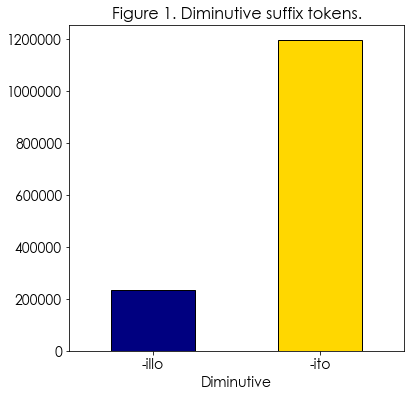

In [59]:
#Build plot

Diminutive_tokens.plot.bar(figsize=(6,6), color=['navy', 'gold'], edgecolor='black', fontsize=14, rot=0)
plt.xlabel('Diminutive', fontsize=14)
plt.title('Figure 1. Diminutive suffix tokens.', fontsize=16)

#Save plot

plt.savefig('../figures/1_diminutive.png', dpi = 300)

- A plot illustrating the ratio of diminutive suffixes by POS (note that I use proportions rather than counts here given the imbalance between categories):

Text(0.5, 0, 'Part of speech')

Text(0.5, 1.0, 'Figure 2. Diminutive suffix tokens by POS.')

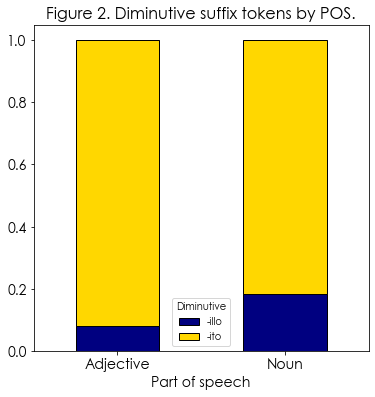

In [60]:
#Build plot

DiminutivexPOS.plot(kind='bar',stacked='True', figsize=(6,6), color=['navy', 'gold'], edgecolor='black', fontsize=14,
                                  rot=0)
plt.xlabel('Part of speech', fontsize=14)
plt.title('Figure 2. Diminutive suffix tokens by POS.', fontsize=16)

#Save plot

plt.savefig('../figures/2_diminutive_POS.png', dpi = 300)

- Interesting information here, as of now it appears that there's a bigger gap in usage depending on the part of speech. *-illo* appears to be less common with adjectives. For nouns, the proportion amounts to nearly 19%, whereas for adjectives it is less than 10%. Lastly and most importantly, the ratio of diminutive suffixes used by variety. Below is a reminder of the varieties considered in the order that they appear followed by the plot:

In [61]:
for (x,y) in variety_tups:
    print(x)

Argentina
Bolivia
Chile
Colombia
Costa Rica
Cuba
Dominican Republic
Ecuador
Spain
Guatemala
Honduras
Mexico
Nicaragua
Panama
Peru
Puerto Rico
Paraguay
El Salvador
United States
Uruguay


Text(0.5, 1.0, 'Figure 3. Diminutive suffix tokens by variety.')

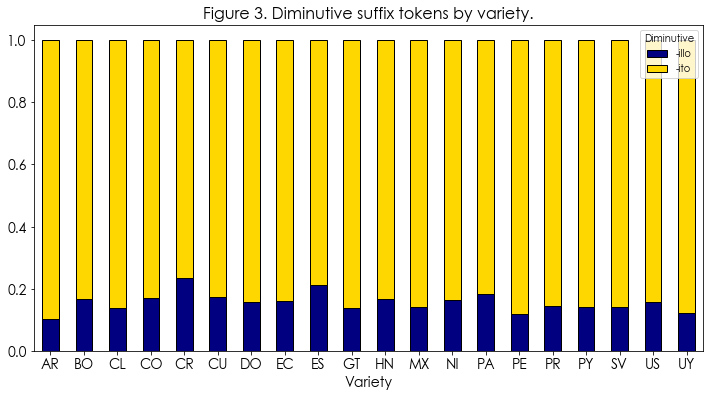

In [62]:
#Build plot

DiminutivexVariety.plot(kind='bar',stacked='True', figsize=(12,6), color=['navy', 'gold'], edgecolor='black', 
                        fontsize=14, rot=0)
plt.title('Figure 3. Diminutive suffix tokens by variety.', fontsize=16)

#Save plot

plt.savefig('../figures/3_diminutive_variety.png', dpi = 300)

- Again, some more interesting information. The ratio is similar for most countries other than Spain and (interestingly) Costa Rica, which are the only varieties where -illo eclipses the 20% threshold (21 and 23%, respectively). Note that this is preliminary given that I'm working with token counts and that I'm not using statistical measures yet, but it's a good point of departure.

## 4. Storing files

In [63]:
#Master data frame

master_DF.to_pickle('pkl/master_DF.pkl')

#Lexicon

lexicon.to_pickle('pkl/lexicon.pkl')